In [1]:
import pandas as pd
import numpy as np
import torch
import os
from utils import *
from model import *
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Set up the datasets

In [3]:
train_B = pd.read_csv("../processed_data/train_B.csv", header=None)
test_B = pd.read_csv("../processed_data/test_B.csv", header=None)
train_R = pd.read_csv("../processed_data/train_R.csv", header=None)
test_R = pd.read_csv("../processed_data/test_R.csv", header=None)

In [4]:
train_B = torch.tensor(np.array(train_B), dtype=torch.float32)
test_B = torch.tensor(np.array(test_B), dtype=torch.float32)
train_R = torch.tensor(np.array(train_R), dtype=torch.float32)
test_R = torch.tensor(np.array(test_R), dtype=torch.float32)

train_RB = torch.concat([train_B, train_R])
test_RB = torch.concat([test_B, test_R])

# Shuffle train_RB
train_RB_indices = torch.randperm(train_RB.size(0))
train_RB = train_RB[train_RB_indices]

# Shuffle test_RB
test_RB_indices = torch.randperm(test_RB.size(0))
test_RB = test_RB[test_RB_indices]

In [5]:
training_sets = [train_R, train_B, train_R, train_B, train_RB, train_RB, train_RB]
test_sets =  [test_R, test_B, test_B, test_R, test_R, test_B, test_RB]
# test_errors = []
combination_name = ['R/R', 'B/B', 'R/B', 'B/R', 'R+B/R', 'R+B/B', 'R+B/R+B']

### Define the hyperparameters

In [6]:
hparams = {
    'input_size': 21,            # Number of input features (e.g., number of columns in your dataset)
    'hidden_sizes': [3],        # List of numbers of neurons of each hidden layer
    'output_size': 1,            # Number of output neurons (e.g., 1 for binary classification)
    'num_epochs': 10,            # Number of training epochs
    'batch_size': 32,            # Batch size for training
    'learning_rate': 0.001,      # Learning rate for the optimizer
    'lr_decay_step_size': 10,    # Step size for learning rate decay
    'lr_decay_gamma': 0.1,       # Multiplicative factor of learning rate decay
    'random_state': 42           # Random seed for reproducibility
}

In [7]:
input_size = hparams['input_size']
# hidden_sizes = hparams['hidden_sizes']
output_size = hparams['output_size']
num_epochs = hparams['num_epochs']
batch_size = hparams['batch_size']
learning_rate = hparams['learning_rate']
lr_decay_step_size = hparams['lr_decay_step_size']
lr_decay_gamma = hparams['lr_decay_gamma']

### Select hidden sizes

In [43]:
def calculate_fcn_parameters(input_size, hidden_layers, output_size):
    layers = [input_size] + hidden_layers + [output_size]
    total_params = 0
    for i in range(len(layers) - 1):
        weights = layers[i] * layers[i + 1]
        biases = layers[i + 1]
        total_params += weights + biases
    return total_params

# Define the hidden sizes and the input/output sizes
hidden_sizes = [[1], [2], [3], [4, 2], [5, 2], [5, 3], [6, 3], [10, 4], [12, 5], [16], [32], [16, 16], [32, 16]]
input_size = 21
output_size = 1

# Calculate the number of parameters for each configuration
params_list = []
for hidden in hidden_sizes:
    params = calculate_fcn_parameters(input_size, hidden, output_size)
    params_list.append((hidden, params))

# Sort the configurations by the number of parameters
params_list.sort(key=lambda x: x[1])

# Print the ordered configurations with their parameters
for hidden, params in params_list:
    print(f'Hidden layers: {hidden}, Parameters: {params}')

Hidden layers: [1], Parameters: 24
Hidden layers: [2], Parameters: 47
Hidden layers: [3], Parameters: 70
Hidden layers: [4, 2], Parameters: 101
Hidden layers: [5, 2], Parameters: 125
Hidden layers: [5, 3], Parameters: 132
Hidden layers: [6, 3], Parameters: 157
Hidden layers: [10, 4], Parameters: 269
Hidden layers: [12, 5], Parameters: 335
Hidden layers: [16], Parameters: 369
Hidden layers: [16, 16], Parameters: 641
Hidden layers: [32], Parameters: 737
Hidden layers: [32, 16], Parameters: 1249


In [45]:
# Update hidden_sizes with the ordered configurations
hidden_sizes = [hidden for hidden, params in params_list]

In [46]:
hidden_sizes

[[1],
 [2],
 [3],
 [4, 2],
 [5, 2],
 [5, 3],
 [6, 3],
 [10, 4],
 [12, 5],
 [16],
 [16, 16],
 [32],
 [32, 16]]

In [50]:
# Convert each sublist to a string
hidden_sizes_string = [f"({','.join(map(str, sublist))})" for sublist in hidden_sizes]

In [51]:
hidden_sizes_string

['(1)',
 '(2)',
 '(3)',
 '(4,2)',
 '(5,2)',
 '(5,3)',
 '(6,3)',
 '(10,4)',
 '(12,5)',
 '(16)',
 '(16,16)',
 '(32)',
 '(32,16)']

In [53]:
# Losses for selecting hidden_size
train_losses1 = []
test_losses1 = []

for i in range(len(hidden_sizes)):
    print(f"Training with ANN whose hidden size is {hidden_sizes[i]}")
    model = ANNModel(input_size, hidden_sizes[i], output_size).to(device)

    # Use R+B/R+B to determine which hidden_size to choose
    X_train = training_sets[6][:, :-1].to(device)
    Y_train = training_sets[6][:, -1].to(device)
    X_test = test_sets[6][:, :-1].to(device)
    Y_test = test_sets[6][:, -1].to(device)

    # Create dataloaders for training and test sets
    train_loader = DataLoader(dataset=TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=TensorDataset(X_test, Y_test), batch_size=batch_size, shuffle=False)
    
    # Set the parameters for training and evaluating
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=lr_decay_gamma)
       
    # Train the model
    train_loss = train(model, train_loader, criterion, optimizer, scheduler, num_epochs=num_epochs)
    
    # Evaluate the model
    test_loss = evaluate(model, test_loader, criterion)

    train_losses1.append(train_loss)
    test_losses1.append(test_loss)

Training with ANN whose hidden size is [1]
Epoch [1/10], MSE (train): 0.10385
Epoch [2/10], MSE (train): 0.10394
Epoch [3/10], MSE (train): 0.10403
Epoch [4/10], MSE (train): 0.10403
Epoch [5/10], MSE (train): 0.10403
Epoch [6/10], MSE (train): 0.10403
Epoch [7/10], MSE (train): 0.10403
Epoch [8/10], MSE (train): 0.10403
Epoch [9/10], MSE (train): 0.10403
Epoch [10/10], MSE (train): 0.10403
MSE (evaluate): 0.1474
Training with ANN whose hidden size is [2]
Epoch [1/10], MSE (train): 0.13606
Epoch [2/10], MSE (train): 0.12816
Epoch [3/10], MSE (train): 0.1231
Epoch [4/10], MSE (train): 0.11291
Epoch [5/10], MSE (train): 0.09726
Epoch [6/10], MSE (train): 0.054182
Epoch [7/10], MSE (train): 0.050775
Epoch [8/10], MSE (train): 0.049427
Epoch [9/10], MSE (train): 0.048718
Epoch [10/10], MSE (train): 0.048301
MSE (evaluate): 0.074343
Training with ANN whose hidden size is [3]
Epoch [1/10], MSE (train): 0.10609
Epoch [2/10], MSE (train): 0.14097
Epoch [3/10], MSE (train): 0.12889
Epoch [4/10]

In [54]:
train_losses1

[[0.1038450375199318,
  0.10394074022769928,
  0.10402975976467133,
  0.10403141379356384,
  0.1040315330028534,
  0.10403154790401459,
  0.10403154790401459,
  0.10403154790401459,
  0.10403154790401459,
  0.10403154790401459],
 [0.13605926930904388,
  0.12815511226654053,
  0.12310435622930527,
  0.11290715634822845,
  0.09726037085056305,
  0.0541820228099823,
  0.05077545344829559,
  0.049427371472120285,
  0.04871758818626404,
  0.04830053821206093],
 [0.10608848929405212,
  0.14097058773040771,
  0.1288866549730301,
  0.12045421451330185,
  0.10093860328197479,
  0.05762314423918724,
  0.05156556889414787,
  0.049801696091890335,
  0.04890123009681702,
  0.048386234790086746],
 [0.10182222723960876,
  0.10194360464811325,
  0.12921951711177826,
  0.07804296165704727,
  0.03133808448910713,
  0.03344782069325447,
  0.02901339903473854,
  0.030972430482506752,
  0.03210826963186264,
  0.03140781447291374],
 [0.033303748816251755,
  0.03143623471260071,
  0.02486760914325714,
  0.02

In [55]:
test_losses1

[0.14740458113417845,
 0.07434345040138464,
 0.0743368849755663,
 0.04945522218862845,
 0.04511488690720082,
 0.045644347260468496,
 0.03762600384384791,
 0.042718951580435274,
 0.03459153072634979,
 0.042094907321422514,
 0.03449897971415248,
 0.03874499401901351,
 0.033050229441968296]

In [56]:
train_losses_1 = pd.DataFrame(np.array(train_losses1).T, columns=hidden_sizes_string)

In [57]:
train_losses_1

,(1),(2),(3),"(4,2)","(5,2)","(5,3)","(6,3)","(10,4)","(12,5)",(16),"(16,16)",(32),"(32,16)"
0,0.103845,0.136059,0.106088,0.101822,0.033304,0.111146,0.076989,0.086924,0.081023,0.072747,0.036060,0.052478,0.033516
1,0.103941,0.128155,0.140971,0.101944,0.031436,0.023635,0.018529,0.026271,0.026010,0.035520,0.026801,0.064923,0.022760
2,0.104030,0.123104,0.128887,0.129220,0.024868,0.022407,0.020052,0.024293,0.021673,0.028046,0.022666,0.022696,0.021543
3,0.104031,0.112907,0.120454,0.078043,0.024724,0.021869,0.021922,0.021825,0.023155,0.023698,0.016819,0.017269,0.026287
4,0.104032,0.097260,0.100939,0.031338,0.023539,0.021416,0.019733,0.020407,0.023023,0.016372,0.017500,0.016833,0.025022
5,0.104032,0.054182,0.057623,0.033448,0.022946,0.021074,0.019341,0.019460,0.021248,0.015575,0.015722,0.018398,0.020684
6,0.104032,0.050775,0.051566,0.029013,0.022843,0.020682,0.018640,0.018612,0.019839,0.019984,0.015961,0.023239,0.019595
7,0.104032,0.049427,0.049802,0.030972,0.022590,0.020417,0.019049,0.017522,0.020267,0.020816,0.018184,0.017618,0.020316
8,0.104032,0.048718,0.048901,0.032108,0.022449,0.020178,0.018213,0.016901,0.020134,0.022040,0.017353,0.020885,0.020764
9,0.104032,0.048301,0.048386,0.031408,0.022257,0.019894,0.018414,0.016692,0.019593,0.021895,0.016593,0.022234,0.021703


In [58]:
test_losses_1 = pd.DataFrame(np.array(test_losses1).reshape(-1, 1).T, columns= hidden_sizes_string)

In [59]:
test_losses_1

,(1),(2),(3),"(4,2)","(5,2)","(5,3)","(6,3)","(10,4)","(12,5)",(16),"(16,16)",(32),"(32,16)"
0,0.147405,0.074343,0.074337,0.049455,0.045115,0.045644,0.037626,0.042719,0.034592,0.042095,0.034499,0.038745,0.03305


In [60]:
train_losses_1.to_csv('../outputs/train_losses_wrt_hidden_sizes.csv', index=None)
test_losses_1.to_csv('../outputs/test_losses_wrt_hidden_sizes.csv', index=None)

### Train and test on different datasets

In [79]:
hidden_sizes = [12, 5]

In [80]:
train_losses = []
test_losses = []

for i in range(len(training_sets)):
    print(f'Training for {combination_name[i]}')

    model = ANNModel(input_size, hidden_sizes, output_size).to(device)
  
    X_train = training_sets[i][:, :-1].to(device)
    Y_train = training_sets[i][:, -1].to(device)
    X_test = test_sets[i][:, :-1].to(device)
    Y_test = test_sets[i][:, -1].to(device)

    # Create dataloaders for training and test sets
    train_loader = DataLoader(dataset=TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=TensorDataset(X_test, Y_test), batch_size=batch_size, shuffle=False)
    
    # Set the parameters for training and evaluating
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step_size, gamma=lr_decay_gamma)
       
    # Train the model
    train_loss = train(model, train_loader, criterion, optimizer, scheduler, num_epochs=num_epochs)
    
    # Evaluate the model
    test_loss = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    

Training for R/R
Epoch [1/10], MSE (train): 0.055851
Epoch [2/10], MSE (train): 0.031464
Epoch [3/10], MSE (train): 0.020183
Epoch [4/10], MSE (train): 0.019996
Epoch [5/10], MSE (train): 0.018885
Epoch [6/10], MSE (train): 0.01766
Epoch [7/10], MSE (train): 0.018899
Epoch [8/10], MSE (train): 0.019567
Epoch [9/10], MSE (train): 0.015733
Epoch [10/10], MSE (train): 0.016671
MSE (evaluate): 0.029388
Training for B/B
Epoch [1/10], MSE (train): 0.026092
Epoch [2/10], MSE (train): 0.021793
Epoch [3/10], MSE (train): 0.020377
Epoch [4/10], MSE (train): 0.018695
Epoch [5/10], MSE (train): 0.018663
Epoch [6/10], MSE (train): 0.017899
Epoch [7/10], MSE (train): 0.019517
Epoch [8/10], MSE (train): 0.021632
Epoch [9/10], MSE (train): 0.021458
Epoch [10/10], MSE (train): 0.02224
MSE (evaluate): 0.053978
Training for R/B
Epoch [1/10], MSE (train): 0.076092
Epoch [2/10], MSE (train): 0.030811
Epoch [3/10], MSE (train): 0.024911
Epoch [4/10], MSE (train): 0.021491
Epoch [5/10], MSE (train): 0.020919

### Save train and test losses

In [81]:
train_losses

[[0.055851396173238754,
  0.03146390616893768,
  0.020182941108942032,
  0.019996287301182747,
  0.018885405734181404,
  0.017660344019532204,
  0.018898893147706985,
  0.019566748291254044,
  0.015733106061816216,
  0.016671176999807358],
 [0.02609156258404255,
  0.021793244406580925,
  0.02037677727639675,
  0.018694506958127022,
  0.018662653863430023,
  0.01789860613644123,
  0.01951739564538002,
  0.02163201943039894,
  0.021458059549331665,
  0.022239508107304573],
 [0.07609204202890396,
  0.030811289325356483,
  0.024911336600780487,
  0.021490707993507385,
  0.020918866619467735,
  0.020898757502436638,
  0.02136234939098358,
  0.021240780130028725,
  0.022462354972958565,
  0.023920945823192596],
 [0.1559421569108963,
  0.06439673155546188,
  0.0466219000518322,
  0.04225991666316986,
  0.04157182574272156,
  0.03686901926994324,
  0.03653377294540405,
  0.037765223532915115,
  0.03691764548420906,
  0.013527690432965755],
 [0.031443040817976,
  0.019460737705230713,
  0.01752

In [ ]:
train_losses = pd.DataFrame(np.array(train_losses).T, columns=combination_name)

In [83]:
train_losses

,R/R,B/B,R/B,B/R,R+B/R,R+B/B,R+B/R+B
0,0.055851,0.026092,0.076092,0.155942,0.031443,0.101566,0.035336
1,0.031464,0.021793,0.030811,0.064397,0.019461,0.140522,0.020594
2,0.020183,0.020377,0.024911,0.046622,0.017522,0.021763,0.018355
3,0.019996,0.018695,0.021491,0.042260,0.017758,0.019769,0.018108
4,0.018885,0.018663,0.020919,0.041572,0.016696,0.016997,0.017106
5,0.017660,0.017899,0.020899,0.036869,0.019698,0.017063,0.017791
6,0.018899,0.019517,0.021362,0.036534,0.018323,0.018929,0.017886
7,0.019567,0.021632,0.021241,0.037765,0.018297,0.017936,0.018251
8,0.015733,0.021458,0.022462,0.036918,0.018759,0.016788,0.017794
9,0.016671,0.022240,0.023921,0.013528,0.019017,0.018958,0.017375


In [84]:
test_losses

[0.029388132511393963,
 0.05397803860107201,
 0.11234448870519304,
 0.252104209984719,
 0.03159071174286735,
 0.06394775515068112,
 0.04066175579033107]

In [86]:
test_losses = pd.DataFrame(np.array(test_losses).reshape(-1, 1).T, columns=combination_name)
test_losses

,R/R,B/B,R/B,B/R,R+B/R,R+B/B,R+B/R+B
0,0.029388,0.053978,0.112344,0.252104,0.031591,0.063948,0.040662


In [88]:
train_losses.to_csv('../outputs/train_losses_wrt_datasets.csv', index=None)
test_losses.to_csv('../outputs/test_losses_wrt_datasets.csv', index=None)

### Save the model state

In [91]:
torch.save(model.state_dict(), '../outputs/ann_model_12_5.pth')

In [95]:
X_B = torch.tensor(test_B[:, : -1], dtype=torch.float32).to(device)
X_R = torch.tensor(test_R[:, : -1], dtype=torch.float32).to(device)

C:\Users\KJ\AppData\Local\Temp\ipykernel_26580\3595534474.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_B = torch.tensor(test_B[:, : -1], dtype=torch.float32).to(device)
C:\Users\KJ\AppData\Local\Temp\ipykernel_26580\3595534474.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_R = torch.tensor(test_R[:, : -1], dtype=torch.float32).to(device)


In [96]:
# Set model to evaluation mode
model.eval()

# Forward pass to get predictions
with torch.no_grad():  # Disable gradient tracking
    Y_hat_B = model(X_B)
    Y_hat_R = model(X_R)


In [101]:
Y_pred_B = Y_hat_B.cpu().numpy()

In [102]:
Y_pred_R = Y_hat_R.cpu().numpy()

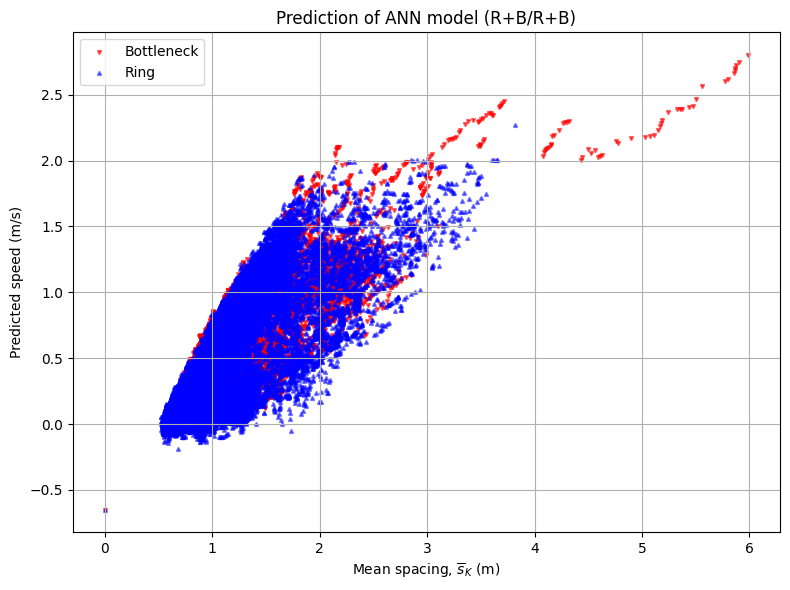

In [149]:
plt.figure(figsize=(8, 6))  # Optional: Set the size of the figure

plt.scatter(test_B[:, 0]/100, Y_pred_B, s=5, c='red', alpha=0.6, marker='v', linewidths=1.5, label='Bottleneck')
plt.scatter(test_R[:, 0]/100, Y_pred_R, s=5, c='blue', alpha=0.5, marker='^', linewidths=1.5, label='Ring')
# s: size of the points (can be a scalar or an array)
# c: color of the points
# alpha: transparency of the points (0 for transparent, 1 for opaque)
# marker: marker style (e.g., 'o' for circle, 's' for square, etc.)
# edgecolors: color of marker edges
# linewidths: thickness of marker edges

plt.title('Prediction of ANN model (R+B/R+B)')
plt.xlabel('Mean spacing, $\overline{s}_K$ (m)')
plt.ylabel('Predicted speed (m/s)')
plt.grid(True)  # Optional: Add gridlines
plt.tight_layout()  # Optional: Adjust layout to prevent clipping of labels
plt.legend()
plt.show()

In [142]:
sk_B = test_B[:, 0]/100
sk_B = sk_B.cpu().numpy()
sk_B, sk_B.shape

(array([0.       , 1.1811918, 0.9771123, ..., 1.126689 , 1.1864178,
        0.97275  ], dtype=float32),
 (27147,))

In [132]:
Y_pred_B, Y_pred_B.shape

(array([[-0.6487872 ],
        [ 0.7881556 ],
        [ 0.5144529 ],
        ...,
        [ 0.7910554 ],
        [ 0.94601244],
        [ 0.41112083]], dtype=float32),
 (27147, 1))

In [163]:
pred_B = np.column_stack((sk_B, Y_pred_B))

# Create a DataFrame
dfB = pd.DataFrame(pred_B, columns=['sk', 'pred'])

# Save to CSV
dfB.to_csv('../outputs/pred_B.csv', index=False)

In [148]:
from scipy.optimize import curve_fit


# Example data (replace with your actual data)
sk_data = sk_B
v_data = Y_pred_B.reshape(-1,)

# Initial guess for parameters (v0, l, T)
initial_guess = (1.5, 0.6, 0.7)

# Perform curve fitting
params, covariance = curve_fit(weidmann_model, sk_data, v_data, p0=initial_guess)

# Extract fitted parameters
v0_fit_B, l_fit_B, T_fit_B = params

# Print fitted parameters
print("Fitted parameters:")
print(f"v0_B = {v0_fit_B}")
print(f"l_B = {l_fit_B}")
print(f"T_B = {T_fit_B}")

Fitted parameters:
v0_B = 2.6742090783751093
l_B = 0.37228782061362825
T_B = 1.0696110455256351


In [145]:
sk_R = test_R[:, 0]/100
sk_R = sk_R.cpu().numpy()
sk_R, sk_R.shape

(array([0.        , 0.9860785 , 0.67726296, ..., 0.76856047, 1.540321  ,
        0.8340692 ], dtype=float32),
 (101516,))

In [146]:
Y_pred_R, Y_pred_R.shape

(array([[-0.6487872 ],
        [ 0.19180942],
        [ 0.1800335 ],
        ...,
        [ 0.22080112],
        [ 1.3519688 ],
        [ 0.2299084 ]], dtype=float32),
 (101516, 1))

In [164]:
pred_R = np.column_stack((sk_R, Y_pred_R))

# Create a DataFrame
dfR = pd.DataFrame(pred_R, columns=['sk', 'pred'])

# Save to CSV
dfR.to_csv('../outputs/pred_R.csv', index=False)

In [147]:
# Example data (replace with your actual data)
sk_data = sk_R
v_data = Y_pred_R.reshape(-1,)

# Initial guess for parameters (v0, l, T)
initial_guess = (1.5, 0.6, 0.7)

# Perform curve fitting
params, covariance = curve_fit(weidmann_model, sk_data, v_data, p0=initial_guess)

# Extract fitted parameters
v0_fit_R, l_fit_R, T_fit_R = params

# Print fitted parameters
print("Fitted parameters:")
print(f"v0_R = {v0_fit_R}")
print(f"l_R = {l_fit_R}")
print(f"T_R = {T_fit_R}")

Fitted parameters:
v0_R = 1.9411310682134728
l_R = 0.584684091106252
T_R = 0.8100652611585263


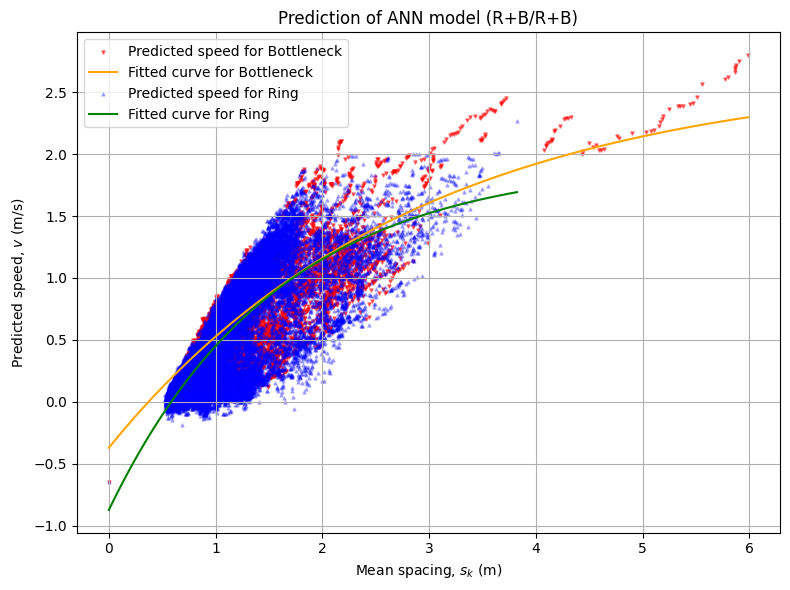

In [162]:
# Generate smooth curve based on fitted parameters
sk_smooth_B = np.linspace(min(sk_B), max(sk_B), 100)
v_smooth_B = weidmann_model(sk_smooth_B, v0_fit_B, l_fit_B, T_fit_B)

sk_smooth_R = np.linspace(min(sk_R), max(sk_R), 100)
v_smooth_R = weidmann_model(sk_smooth_R, v0_fit_R, l_fit_R, T_fit_R)

# Plotting the original data and fitted curve
plt.figure(figsize=(8, 6))
plt.scatter(sk_B, Y_pred_B.reshape(-1,), s=5, c='red', alpha=0.5, marker='v', label='Predicted speed for Bottleneck')
plt.plot(sk_smooth_B, v_smooth_B, c='orange', alpha=1, label='Fitted curve for Bottleneck')

plt.scatter(sk_R, Y_pred_R.reshape(-1,), s=5, c='blue', alpha=0.25, marker='^', label='Predicted speed for Ring')
plt.plot(sk_smooth_R, v_smooth_R, c='green', alpha=1, label='Fitted curve for Ring')

plt.title('Prediction of ANN model (R+B/R+B)')
plt.xlabel('Mean spacing, $s_k$ (m)')
plt.ylabel('Predicted speed, $v$ (m/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()